# Changes in this version
* Optimize loading & processing audio for speed
* Split loading audio into 2 functions

# CREPE Trainer

This notebook can create CREPE models and train them on steelpan data.

To use the notebook as is, download the downsampled audio ("tiny_16kHz/") and make sure that the dirpaths for the train and validation sets are correct. Also download the .h5 files from the CREPE repo's "models" branch if you want to train from existing weights.

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
# This code allows for the GPU to be utilized properly.
tf.autograph.set_verbosity(0)
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

print(physical_devices)
print("If the above list is empty, then TF won't use any accelerator")

2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
If the above list is empty, then TF won't use any accelerator


## Model builder

This code is modified a bit from the repo as it normally stores the models in a dict, which I think is unnecessary for our purposes.

You can also load weights from an existing .h5 file. I began training by loading the weights of "model-full.h5" from the marl/crepe models branch. The weights for the model trained on steelpan data is named "new-crepe-full.h5" and is in the Drive folder.

In [2]:
import os

# store as a global variable, since we only support a few models for now
models = {
    'tiny': None,
    'small': None,
    'medium': None,
    'large': None,
    'full': None
}

# the model is trained on 16kHz audio
model_srate = 16000
model_size = "medium"

def make_model(model_capacity, metrics, weights=None):
    '''
    model_capacity: tiny, small, medium, large, full
    weights: path of .h5 weights file
    '''

    from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
    from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
    from tensorflow.keras.models import Model

    capacity_multiplier = {
        'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32
    }[model_capacity]

    layers = [1, 2, 3, 4, 5, 6]
    filters = [n * capacity_multiplier for n in [32, 4, 4, 4, 8, 16]]
    widths = [512, 64, 64, 64, 64, 64]
    strides = [(4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]

    x = Input(shape=(1024,), name='input', dtype='float32')
    y = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(x)

    for l, f, w, s in zip(layers, filters, widths, strides):
        y = Conv2D(f, (w, 1), strides=s, padding='same',
                    activation='relu', name="conv%d" % l)(y)
        y = BatchNormalization(name="conv%d-BN" % l)(y)
        y = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
                        name="conv%d-maxpool" % l)(y)
        y = Dropout(0.25, name="conv%d-dropout" % l)(y)

    y = Permute((2, 1, 3), name="transpose")(y)
    y = Flatten(name="flatten")(y)
    y = Dense(360, activation='sigmoid', name="classifier")(y)

    model = Model(inputs=x, outputs=y)

    if weights != None:
        model.load_weights(weights)
    model.compile('adam', 'binary_crossentropy', metrics=metrics)

    models[model_capacity] = model

    return model

In [3]:
def db_to_pow(db):
  return 10**(db / 10)

In [4]:
def frame_energy(frame):
  '''Calculates the average energy for a frame
    
    Parameters
    ----------
    frame : np.array
      audio frame in np.float32 format

    Returns
    -------
    average_energy : float
      Average energy level for frame
  '''

  # Square the sample values to convert to energy values
  energy = frame**2

  # Sum the energy values to get total energy
  total_energy = np.sum(energy)

  # Divide by length to get average energy
  return total_energy / len(frame)

## Loading .wav files

An issue we might need to discuss is the truncation of the data. Since not all of the steelpan audio is the same length, I've made it so that all the audio is just trimmed to the length of the shortest audio file.

To generate the labels, each filename is parsed to get the MIDI pitch. Audio data is returned in a 2D array and labels are returned in a 1D array.

## Data formatting

Audio is formatted according to how CREPE does it, but is formatted into batch format for input into model.fit(). Step size defaults to 10ms like in CREPE.

The label data is scaled and encoded into one-hots to fit the model's bucketed output. There are 360 outputs, but only 29 actually appear as labels (MIDI pitches 60-89).

Data is being trimmed by dBFS levels, which I've set to -30 for now. Anything -40 and below trims almost nothing, and -30 trims a good amount (I think it does need more tuning).

The one-hotted labels have Gaussian blurring applied to them too (as specified in the other notebook).

In [5]:
import soundfile, os
def process_audio_file(filepath, threshold_pow, step_size=10):
    '''
        Processes a single audio file by formatting it into frames and extracting the label.

        Parameters
        ----------
        filepath : string
        Filepath for audio.

        threshold_pow : float
        Frames with average energy less than this are clipped.

        step_size : int
        Space between each frame (in milliseconds).

        Returns
        -------
        frames : np.array dtype=float
        The normalized and clipped audio, in frame form.

        labels : int[]
        The pitch of the audio file, in MIDI. It's duplicated
        because the model requires one label for each frame.
    '''
    audio, _ = soundfile.read(filepath)

    # Format the audio data into frames
    hop_length = int(model_srate * step_size / 1000)
    n_frames = 1 + int((len(audio) - 1024) / hop_length)
    frames = as_strided(audio, shape=(1024, n_frames),
                        strides=(audio.itemsize, hop_length * audio.itemsize))
    frames = frames.transpose().copy()

    # Find the first and last frames where levels meet threshold_pow
    for f in range(len(frames)):
        if frame_energy(frames[f]) > threshold_pow:
            start_frame = f
            break

    for f in range(len(frames) - 1, -1, -1):
        if frame_energy(frames[f]) > threshold_pow:
            end_frame = f
            break

    frames = frames[start_frame:end_frame]

    # Normalize each frame
    frames -= np.mean(frames, axis=1)[:, np.newaxis]
    frames /= np.std(frames, axis=1)[:, np.newaxis]

    # Duplicate the label for these frames the set amount of times for the target data
    labels = [int(os.path.basename(filepath).split("_")[0]) for _ in range(end_frame - start_frame)]

    return frames, labels
    

In [6]:
from os import walk
import soundfile
from numpy.lib.stride_tricks import as_strided

def load_audio_batch(dir, threshold_db):
    '''
        Loads and processes all audio files from a directory, returning a single
        array of audio frames and labels. Will load audio from nested dirs as well.

        Parameters
        ----------
        dir : string
        Starting dirpath to load audio from.

        threshold_db : float
        Frames with average energy less than this are clipped (this is converted dB -> power first).

        Returns
        -------
        frames_list : np.array dtype=float
        Audio frames from all loaded audio files.

        labels_list : np.array dtype=float
        The labels for the model. It is formatted as a one-hot vector
        with Gaussian blur applied, so indices closer to the correct
        index are closer to 1 (e.g. if the correct index is 200 then
        index 198 might be 0.953 but index 50 might be 0.067).
    '''

    frames_list = []
    labels_list = []
    threshold_pow = db_to_pow(threshold_db)

    for (dirpath, _, filenames) in walk(dir):
        for filename in filenames:
            frames, labels = process_audio_file(dirpath + "/" + filename, threshold_pow)

            frames_list.append(frames)
            labels_list += labels

    # Assemble frames from all files into one array
    frames_list = np.concatenate(frames_list)

    # Convert MIDI to CREPE cents one-hot vector (0-360)
    labels_list = np.array(tf.one_hot(5 * (np.array(labels_list) - 24), 360))

    # Apply Gaussian blur
    cents_i = np.arange(360)
    for i in range(len(labels_list)):
        cents_true = np.where(labels_list[i] == 1)[0][0]
        labels_list[i] = np.exp(-((20 *(cents_i - cents_true)) ** 2) / (2 * (25 ** 2)))

    return frames_list, labels_list

## Model + Metrics

I only know these three metrics, but there's probably some useful ones that I'm missing.

In [7]:
metrics = ["Accuracy", "Precision", "Recall"]
model = make_model(model_size, metrics, weights="model-" + model_size + ".h5")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
input-reshape (Reshape)      (None, 1024, 1, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 1, 512)       262656    
_________________________________________________________________
conv1-BN (BatchNormalization (None, 256, 1, 512)       2048      
_________________________________________________________________
conv1-maxpool (MaxPooling2D) (None, 128, 1, 512)       0         
_________________________________________________________________
conv1-dropout (Dropout)      (None, 128, 1, 512)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 1, 64)       

## Loading/Formatting data

In [8]:
train, labels = load_audio_batch("tiny_16kHz/train", -60)
val, val_labels = load_audio_batch("tiny_16kHz/validation", -60)

## Training

Any batch size larger than 256 is slower, and also has trouble fitting into VRAM. 20 epochs was an arbitrary choice, which took roughly an hour and a half on a 1650 super.

This also saves the model's weights after training.

In [9]:
history = model.fit(x=train, y=labels, batch_size=256, epochs=20, validation_data=(val, val_labels))
model.save_weights('new-crepe-' + model_size + '.h5')

Epoch 1/20
300/300 [==============================] - 54s 179ms/step - loss: 0.0141 - accuracy: 0.0000e+00 - precision: 0.9603 - recall: 0.0697 - val_loss: 0.0099 - val_accuracy: 0.0000e+00 - val_precision: 0.9814 - val_recall: 0.0863
Epoch 2/20
300/300 [==============================] - 51s 169ms/step - loss: 0.0090 - accuracy: 0.0000e+00 - precision: 0.9901 - recall: 0.0874 - val_loss: 0.0098 - val_accuracy: 0.0000e+00 - val_precision: 0.9897 - val_recall: 0.0877
Epoch 3/20
300/300 [==============================] - 52s 172ms/step - loss: 0.0086 - accuracy: 0.0000e+00 - precision: 0.9955 - recall: 0.0889 - val_loss: 0.0099 - val_accuracy: 0.0000e+00 - val_precision: 0.9913 - val_recall: 0.0879
Epoch 4/20
300/300 [==============================] - 51s 170ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - precision: 0.9976 - recall: 0.0896 - val_loss: 0.0098 - val_accuracy: 0.0000e+00 - val_precision: 0.9930 - val_recall: 0.0881
Epoch 5/20
300/300 [==============================] - 51s 16

## Results

This model has pretty normal graphs except for accuracy, which confuses me so much. Please take a look and see if you can find anything wrong with the data formatting or training, as the accuraccy *does* improve over epochs, but starts out at near 0. Precision and Recall are also suspiciously high, at 0.99+ each. 

It's possible this is simply because I used the wrong metrics, as the model seems to be pretty accurate for individual files from the training/validation set (see below).

In [10]:
from matplotlib import pyplot as plt
def plot(data, labels, x, y):
    '''Plot statistics. Takes a list of lists and list of labels.'''
    
    print(y + " vs. " + x)
    for i in range(len(data)):
        plt.plot(data[i], label=labels[i])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()
    print()

Loss vs. Epoch


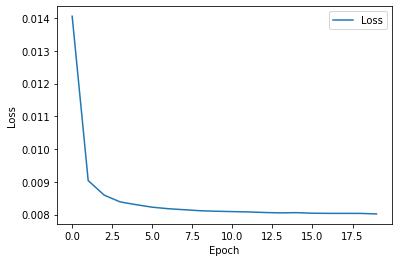


Accuracy, Precision, Recall vs. Epoch


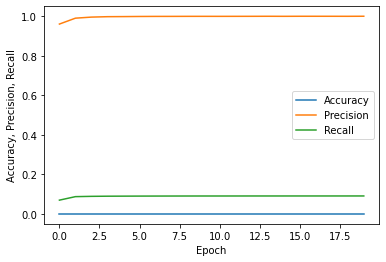

In [11]:
plot((history.history["loss"], ), ("Loss", ), "Epoch", "Loss")
plot((history.history["accuracy"], history.history["precision"], history.history["recall"], ), ("Accuracy", "Precision", "Recall", ), "Epoch", "Accuracy, Precision, Recall")

## Testing for individual sound files

The model seems to be pretty good for the first couple of seconds, but then becomes very inaccurate as the pitch fades.

In [12]:
import soundfile
def load_audio(file):
    wav, sr = soundfile.read(file)
    return wav, sr

In [13]:
from numpy.lib.stride_tricks import as_strided
def predict(audio, sr, step_size=10):
    if len(audio.shape) == 2:
        audio = audio.mean(1)  # make mono
    audio = audio.astype(np.float32)
    if sr != model_srate:
        # resample audio if necessary
        from resampy import resample
        audio = resample(audio, sr, model_srate)

    # make 1024-sample frames of the audio with hop length of 10 milliseconds
    hop_length = int(model_srate * step_size / 1000)
    n_frames = 1 + int((len(audio) - 1024) / hop_length)
    frames = as_strided(audio, shape=(1024, n_frames),
                        strides=(audio.itemsize, hop_length * audio.itemsize))
    frames = frames.transpose().copy()

    # normalize each frame -- this is expected by the model
    frames -= np.mean(frames, axis=1)[:, np.newaxis]
    frames /= np.std(frames, axis=1)[:, np.newaxis]

    # run prediction and convert the frequency bin weights to Hz
    return model(frames)

In [14]:
def as_midi(pred):
    # Convert from output buckets back to MIDI
    midi = (pred.argmax(axis=1) / 5) + 24
    return midi

## Steelpan-trained CREPE vs Original CREPE

In [15]:
import numpy as np

model = make_model(model_size, [], "new-crepe-" + model_size + ".h5")
wav, sr = load_audio("tiny_16kHz/validation/62_train_sample_4.wav")
pred = as_midi(predict(wav, sr).numpy())
print(pred)

[62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.
 62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.
 62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.
 62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.
 62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.
 62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.
 62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.
 62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.
 62.  62.  62.  62.  62.  62.  62.  62.  62.  74.  62.  62.  62.  62.
 62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  74.
 74.  74.  74.  62.  62.  62.  62.  62.  74.  74.  74.  74.  74.  74.
 74.  74.  74.  74.  74.  74.  74.  74.  74.  74.  74.  74.  74.  74.
 74.  74.  73.8 72.  72.  72.  72.  72.  72.  72.  72.  72.  72.  72.
 72.  72.  72.  72.  72.  72.  72.  72.  72.  72.  72.  72.  72.  72.
 72.  72.  72.  72. 